### This notebook shows the core of the proposed framework: evaluation of ANN classifiers with latent space performance metrics

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from latentspace.ml_util import *
import latentspace.datasets as datasets
import latentspace.generative as generative
import latentspace.cnn as cnn
from latentspace.adversarial_generation import *
from latentspace.evaluation_util import EvaluationUtil

### Load a dataset and classifiers

* Comment/uncomment to switch between MNIST, CelebA and LSUN

In [3]:
dataset_info = DatasetInfo.MNIST
#dataset_info = DatasetInfo.CelebA128Gender
#dataset_info = DatasetInfo.LSUN128

class_proportions = None
if dataset_info in [DatasetInfo.CelebA128Gender, DatasetInfo.LSUN128]:
    no_classes = 2
    if dataset_info == DatasetInfo.CelebA128Gender:
        ds = datasets.CelebAData(20)
        classifier_d = "celeba-128"
        class_proportions = np.array([0.583, 0.417])
    elif dataset_info == DatasetInfo.LSUN128:
        ds = datasets.LSUNData()
        classifier_d = "lsun-128"
    gm_loader = lambda label: generative.PIONEER(dataset_info, label, ds, spectral_norm_warming_no_images=25)
elif dataset_info == DatasetInfo.MNIST:
    no_classes = 10
    ds = datasets.MNISTData()
    classifier_d = "mnist"
    gm_loader = lambda label: generative.WGAN(dataset_info, label, ds)
else:
    raise RuntimeError()
if class_proportions is None:
    class_proportions = np.repeat(1 / no_classes, no_classes)

unit_type = 0
    
def load_classifier(prefix: str):
    weights_filename = f"classifiers_architecture{unit_type}/{prefix}_{dataset_info.name}.bin"
    c = cnn.Trainer(classifier_d, ds.get_train_loader, ds.get_test_loader, unit_type=unit_type)
    c.restore_params_from_disk(weights_filename)
    return c

nonrobust_classifier = load_classifier("plain")
robust_classifier    = load_classifier("robust")
classifiers = [nonrobust_classifier, robust_classifier]

def advgen_experiments(adversary: Adversary, noise_eps: float, total_no_images: int):
    decay_factor = EpsDTransformer().eps_to_d(noise_eps)
    for use_generated_images in [False, True]:
        advgen = AdversarialGenerator(None, classifiers, use_generated_images, decay_factor)
        no_images = np.round(class_proportions * total_no_images)
        for i in range(no_classes):
            LogUtil.info(f"*** {classifier_d.upper()}, CLASS {i}, "
                         f"{'GENERATED' if use_generated_images else 'RECONSTRUCTED'} ***")
            LogUtil.info(f"noise_epsilon = {noise_eps:.5f}, decay_factor = {decay_factor:.5f}")
            gm = gm_loader(i)
            advgen.set_generative_model(gm)
            advgen.generate(adversary, int(no_images[i]), True, clear_stat=(i == 0))
            gm.destroy()
        LogUtil.info("*** STATISTICS ***")
        advgen.print_stats(True)

mnist classifier: 23394 trainable parameters
mnist classifier: 23394 trainable parameters


### Quick demonstration how generative models and classifiers work

* For each class, show image reconstructions (as pairs original - reconstructed) and generated images

*** MNIST, CLASS 0 ***
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


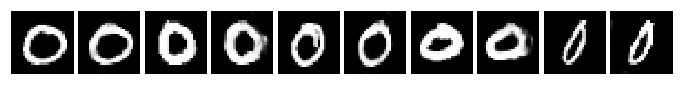

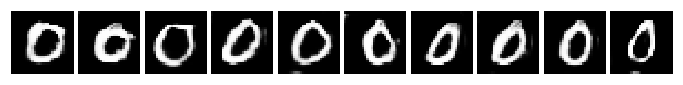

*** MNIST, CLASS 1 ***
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


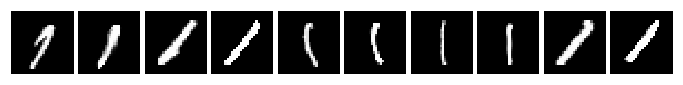

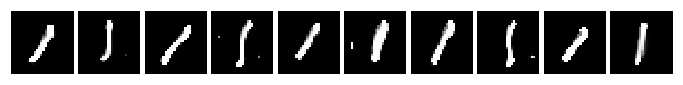

*** MNIST, CLASS 2 ***
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


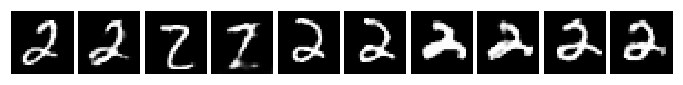

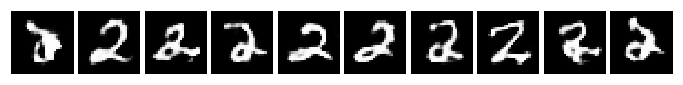

*** MNIST, CLASS 3 ***
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


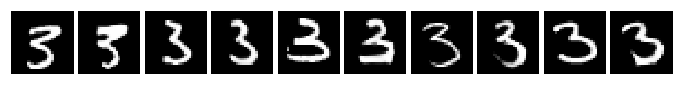

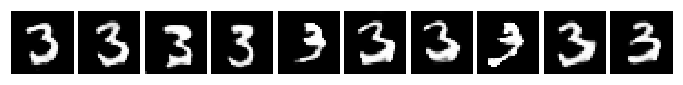

*** MNIST, CLASS 4 ***
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


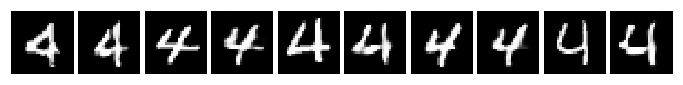

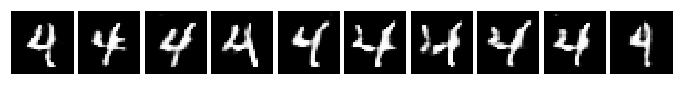

*** MNIST, CLASS 5 ***
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


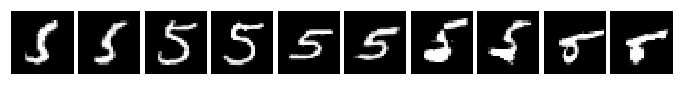

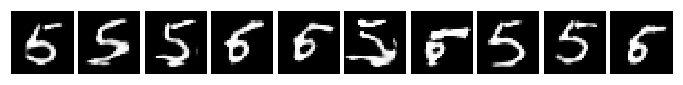

*** MNIST, CLASS 6 ***
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


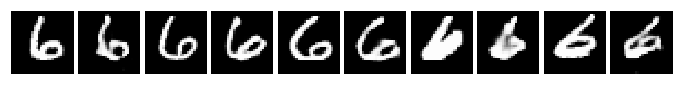

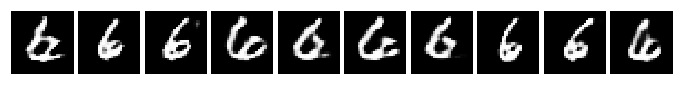

*** MNIST, CLASS 7 ***
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


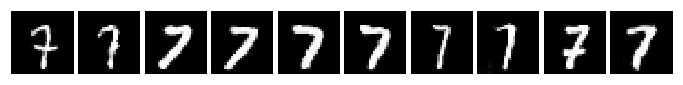

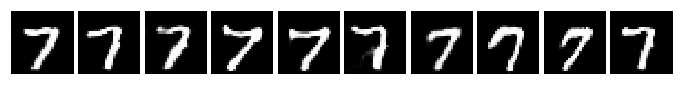

*** MNIST, CLASS 8 ***
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


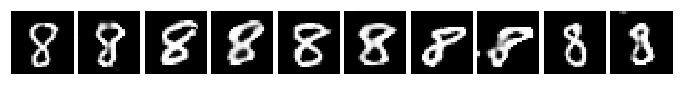

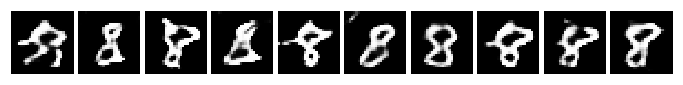

*** MNIST, CLASS 9 ***
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


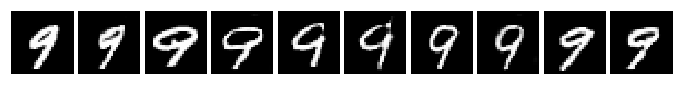

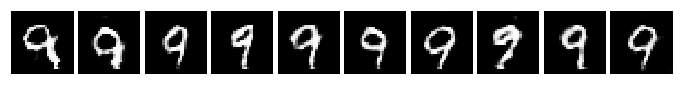

In [4]:
for i in range(no_classes):
    LogUtil.info(f"*** {classifier_d.upper()}, CLASS {i} ***")
    gm = gm_loader(i)
    EvaluationUtil.show_reconstructed_images(gm, 1, 5)
    EvaluationUtil.show_generated_images(gm, 1, 10)
    gm.destroy()

### Show distances between the reconstructed and the original images

In [ ]:
no_images = 10
for i in range(no_classes):
    LogUtil.info(f"*** {classifier_d.upper()}, CLASS {i} ***")
    gm = gm_loader(i)
    EvaluationUtil.show_reconstruction_distance_statistics(gm, no_images)
    gm.destroy()

### Measure local latent noise accuracy (LLNA)

* Also show noise-based perturbations if requested
* Change the numbers of images to get more meaningful results

*** MNIST, CLASS 0 ***
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


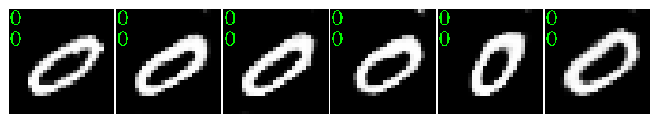

Results for all 2 classifiers one by one:
initial         |   c0: 100.00%   c1: 100.00%
reconstructed   |   c0: 100.00%   c1: 100.00%
perturbed(0.25) |   c0: 100.00%   c1: 100.00%
perturbed(0.50) |   c0: 100.00%   c1: 100.00%
perturbed(0.75) |   c0: 100.00%   c1: 100.00%
perturbed(1.00) |   c0: 100.00%   c1: 100.00%
*** MNIST, CLASS 1 ***
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


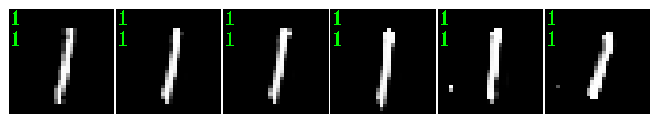

Results for all 2 classifiers one by one:
initial         |   c0: 100.00%   c1: 100.00%
reconstructed   |   c0: 100.00%   c1: 100.00%
perturbed(0.25) |   c0: 100.00%   c1: 100.00%
perturbed(0.50) |   c0: 100.00%   c1: 100.00%
perturbed(0.75) |   c0: 100.00%   c1: 100.00%
perturbed(1.00) |   c0: 100.00%   c1: 100.00%
*** MNIST, CLASS 2 ***
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


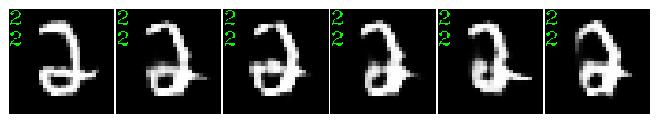

Results for all 2 classifiers one by one:
initial         |   c0: 100.00%   c1: 100.00%
reconstructed   |   c0: 100.00%   c1: 100.00%
perturbed(0.25) |   c0: 100.00%   c1: 100.00%
perturbed(0.50) |   c0: 100.00%   c1: 100.00%
perturbed(0.75) |   c0: 100.00%   c1: 100.00%
perturbed(1.00) |   c0: 100.00%   c1: 100.00%
*** MNIST, CLASS 3 ***
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


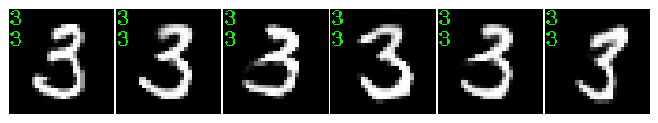

Results for all 2 classifiers one by one:
initial         |   c0: 100.00%   c1: 100.00%
reconstructed   |   c0: 100.00%   c1: 100.00%
perturbed(0.25) |   c0: 100.00%   c1: 100.00%
perturbed(0.50) |   c0: 100.00%   c1: 100.00%
perturbed(0.75) |   c0: 100.00%   c1: 100.00%
perturbed(1.00) |   c0: 100.00%   c1: 100.00%
*** MNIST, CLASS 4 ***
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


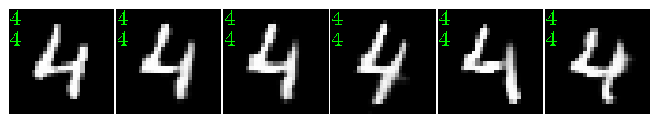

Results for all 2 classifiers one by one:
initial         |   c0: 100.00%   c1: 100.00%
reconstructed   |   c0: 100.00%   c1: 100.00%
perturbed(0.25) |   c0: 100.00%   c1: 100.00%
perturbed(0.50) |   c0: 100.00%   c1: 100.00%
perturbed(0.75) |   c0: 100.00%   c1: 100.00%
perturbed(1.00) |   c0: 100.00%   c1: 100.00%
*** MNIST, CLASS 5 ***
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


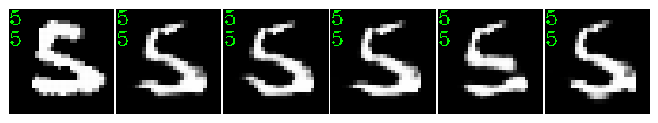

Results for all 2 classifiers one by one:
initial         |   c0: 100.00%   c1: 100.00%
reconstructed   |   c0: 100.00%   c1: 100.00%
perturbed(0.25) |   c0: 100.00%   c1: 100.00%
perturbed(0.50) |   c0: 100.00%   c1: 100.00%
perturbed(0.75) |   c0: 100.00%   c1: 100.00%
perturbed(1.00) |   c0: 100.00%   c1: 100.00%
*** MNIST, CLASS 6 ***
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


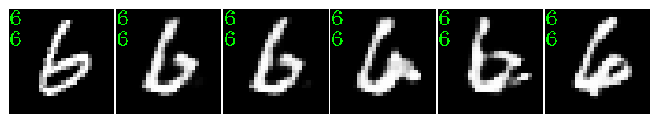

Results for all 2 classifiers one by one:
initial         |   c0: 100.00%   c1: 100.00%
reconstructed   |   c0: 100.00%   c1: 100.00%
perturbed(0.25) |   c0: 100.00%   c1: 100.00%
perturbed(0.50) |   c0: 100.00%   c1: 100.00%
perturbed(0.75) |   c0: 100.00%   c1: 100.00%
perturbed(1.00) |   c0: 100.00%   c1: 100.00%
*** MNIST, CLASS 7 ***
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


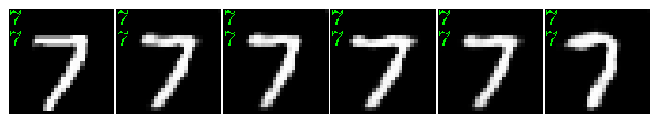

Results for all 2 classifiers one by one:
initial         |   c0: 100.00%   c1: 100.00%
reconstructed   |   c0: 100.00%   c1: 100.00%
perturbed(0.25) |   c0: 100.00%   c1: 100.00%
perturbed(0.50) |   c0: 100.00%   c1: 100.00%
perturbed(0.75) |   c0: 100.00%   c1: 100.00%
perturbed(1.00) |   c0: 100.00%   c1: 100.00%
*** MNIST, CLASS 8 ***
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


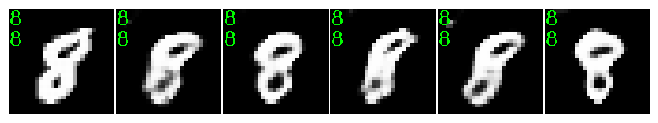

Results for all 2 classifiers one by one:
initial         |   c0: 100.00%   c1: 100.00%
reconstructed   |   c0: 100.00%   c1: 100.00%
perturbed(0.25) |   c0: 100.00%   c1: 100.00%
perturbed(0.50) |   c0: 100.00%   c1: 100.00%
perturbed(0.75) |   c0: 100.00%   c1: 100.00%
perturbed(1.00) |   c0: 100.00%   c1: 100.00%
*** MNIST, CLASS 9 ***
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


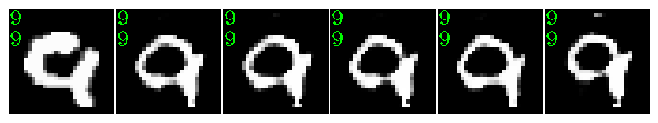

Results for all 2 classifiers one by one:
initial         |   c0: 100.00%   c1: 100.00%
reconstructed   |   c0: 100.00%   c1: 100.00%
perturbed(0.25) |   c0: 100.00%   c1: 100.00%
perturbed(0.50) |   c0: 100.00%   c1: 100.00%
perturbed(0.75) |   c0: 100.00%   c1: 100.00%
perturbed(1.00) |   c0: 100.00%   c1: 100.00%


In [4]:
no_images = 1
no_perturbations_per_image = 1
visualize = True
for i in range(no_classes):
    LogUtil.info(f"*** {classifier_d.upper()}, CLASS {i} ***")
    gm = gm_loader(i)
    RandomPerturbationStatistician(gm, classifiers, no_images, no_perturbations_per_image,
                                   visualize, np.linspace(0.25, 1.00, 4)).process()
    gm.destroy()

### Measure latent adversarial reconstruction/generation severity (LARS, LAGS) by searching for minimum latent adversarial perturbations

* Change the number of images to get more meaningful results
* Metric reports are after each series of reconstructed/generated images
* Latent reconstruction/generation accuracies (LRA, LGA) are also computed
* Norms of minimum latent adversarial perturbations in the original space are also computed

*** MNIST, CLASS 0, RECONSTRUCTED ***
noise_epsilon = 1.00000, decay_factor = 0.29289
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


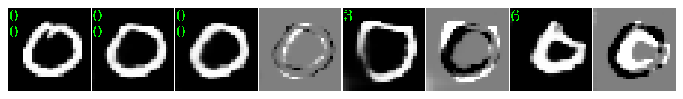

*** MNIST, CLASS 1, RECONSTRUCTED ***
noise_epsilon = 1.00000, decay_factor = 0.29289
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


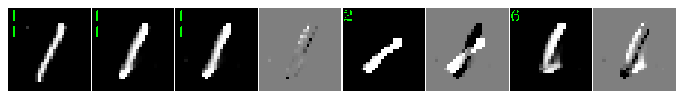

*** MNIST, CLASS 2, RECONSTRUCTED ***
noise_epsilon = 1.00000, decay_factor = 0.29289
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


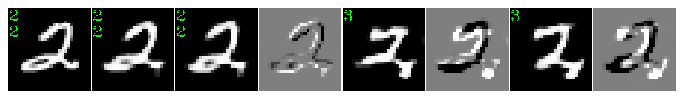

*** MNIST, CLASS 3, RECONSTRUCTED ***
noise_epsilon = 1.00000, decay_factor = 0.29289
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


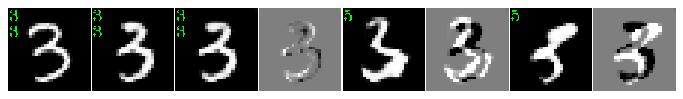

*** MNIST, CLASS 4, RECONSTRUCTED ***
noise_epsilon = 1.00000, decay_factor = 0.29289
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


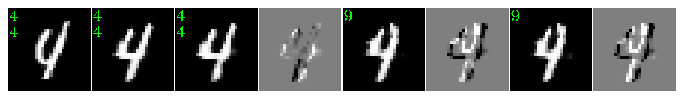

*** MNIST, CLASS 5, RECONSTRUCTED ***
noise_epsilon = 1.00000, decay_factor = 0.29289
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


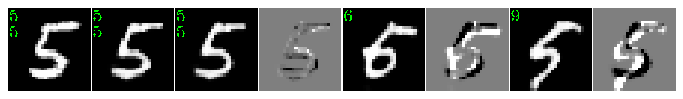

*** MNIST, CLASS 6, RECONSTRUCTED ***
noise_epsilon = 1.00000, decay_factor = 0.29289
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


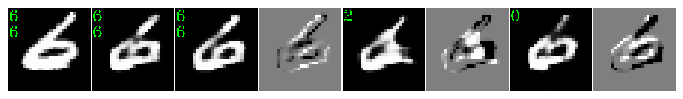

*** MNIST, CLASS 7, RECONSTRUCTED ***
noise_epsilon = 1.00000, decay_factor = 0.29289
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


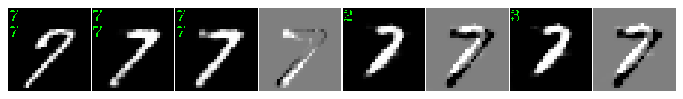

*** MNIST, CLASS 8, RECONSTRUCTED ***
noise_epsilon = 1.00000, decay_factor = 0.29289
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


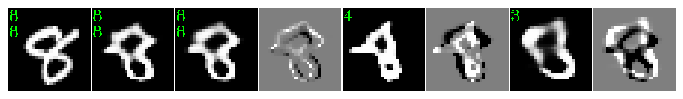

*** MNIST, CLASS 9, RECONSTRUCTED ***
noise_epsilon = 1.00000, decay_factor = 0.29289
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


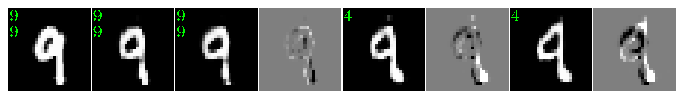

*** STATISTICS ***
Accuracy of classifier 0 on 10      original images: 100.00%
Accuracy of classifier 1 on 10      original images: 100.00%
Accuracy of classifier 0 on 10 reconstructed images: 100.00%
Accuracy of classifier 1 on 10 reconstructed images: 100.00%
Accuracy of classifier 0 on 10       decayed images: 100.00%
Accuracy of classifier 1 on 10       decayed images: 100.00%
Accuracy of classifier 0 on 10     perturbed images: 0.00%
Accuracy of classifier 1 on 10     perturbed images: 0.00%
For classifier 0 and 10 images,             ||dl|| (scaled L2): mean=0.42879, std=0.15275, Q0=0.16919, Q1=0.37050, Q2=0.41397, Q3=0.51477, Q4=0.68758
For classifier 1 and 10 images,             ||dl|| (scaled L2): mean=0.40610, std=0.14547, Q0=0.13229, Q1=0.32867, Q2=0.39738, Q3=0.52266, Q4=0.60616
For classifier 0 and 10 images, ||l + dl|| - ||l|| (scaled L2): mean=0.16146, std=0.08804, Q0=0.03574, Q1=0.10005, Q2=0.16064, Q3=0.20759, Q4=0.28733
For classifier 1 and 10 images, ||l + dl|| - ||

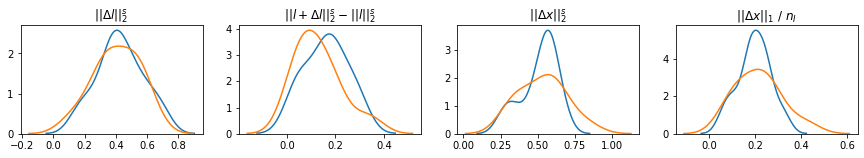

*** MNIST, CLASS 0, GENERATED ***
noise_epsilon = 1.00000, decay_factor = 0.29289
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


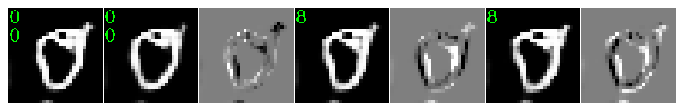

*** MNIST, CLASS 1, GENERATED ***
noise_epsilon = 1.00000, decay_factor = 0.29289
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


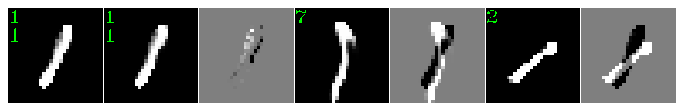

*** MNIST, CLASS 2, GENERATED ***
noise_epsilon = 1.00000, decay_factor = 0.29289
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


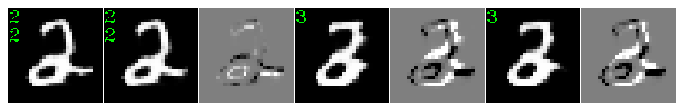

*** MNIST, CLASS 3, GENERATED ***
noise_epsilon = 1.00000, decay_factor = 0.29289
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


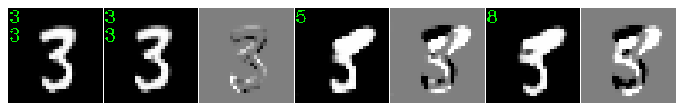

*** MNIST, CLASS 4, GENERATED ***
noise_epsilon = 1.00000, decay_factor = 0.29289
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


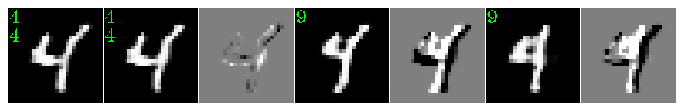

*** MNIST, CLASS 5, GENERATED ***
noise_epsilon = 1.00000, decay_factor = 0.29289
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


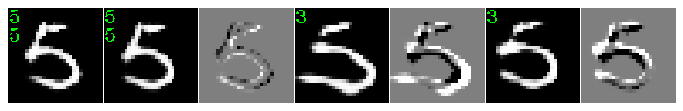

*** MNIST, CLASS 6, GENERATED ***
noise_epsilon = 1.00000, decay_factor = 0.29289
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


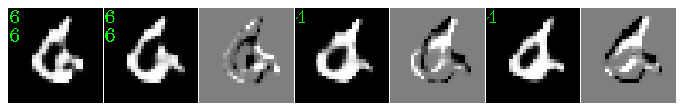

*** MNIST, CLASS 7, GENERATED ***
noise_epsilon = 1.00000, decay_factor = 0.29289
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


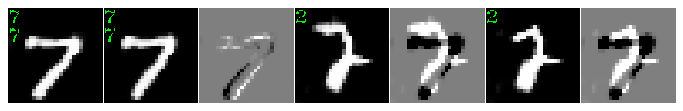

*** MNIST, CLASS 8, GENERATED ***
noise_epsilon = 1.00000, decay_factor = 0.29289
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


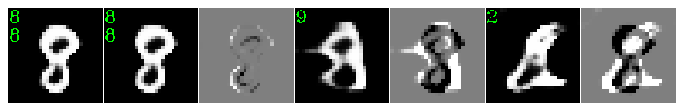

*** MNIST, CLASS 9, GENERATED ***
noise_epsilon = 1.00000, decay_factor = 0.29289
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


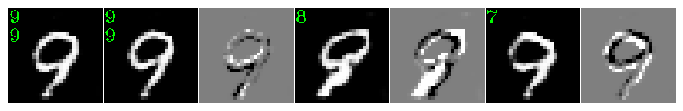

*** STATISTICS ***
Accuracy of classifier 0 on 10     generated images: 100.00%
Accuracy of classifier 1 on 10     generated images: 100.00%
Accuracy of classifier 0 on 10       decayed images: 100.00%
Accuracy of classifier 1 on 10       decayed images: 100.00%
Accuracy of classifier 0 on 10     perturbed images: 0.00%
Accuracy of classifier 1 on 10     perturbed images: 0.00%
For classifier 0 and 10 images,             ||dl|| (scaled L2): mean=0.39428, std=0.21074, Q0=0.12543, Q1=0.22249, Q2=0.36339, Q3=0.55392, Q4=0.77978
For classifier 1 and 10 images,             ||dl|| (scaled L2): mean=0.34623, std=0.14303, Q0=0.14390, Q1=0.24670, Q2=0.34718, Q3=0.45188, Q4=0.54705
For classifier 0 and 10 images, ||l + dl|| - ||l|| (scaled L2): mean=0.16319, std=0.13707, Q0=0.03274, Q1=0.05965, Q2=0.12727, Q3=0.20876, Q4=0.46679
For classifier 1 and 10 images, ||l + dl|| - ||l|| (scaled L2): mean=0.10538, std=0.08706, Q0=0.01094, Q1=0.04957, Q2=0.07157, Q3=0.16938, Q4=0.24947
For classifier 0 an

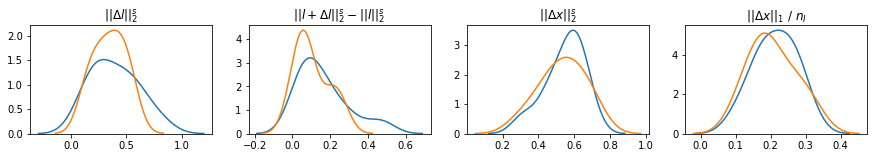

In [5]:
total_images = 10
max_rho, noise_eps = 2.5, 1.0
if dataset_info == DatasetInfo.MNIST:
    # search with restarts
    adversary = PGDAdversary(max_rho, 50, 0.05, True, 0, verbose=0, n_repeat=12, repeat_mode="min")
else:
    # search without restarts, with a smaller learning rate
    adversary = PGDAdversary(max_rho, 1250, 0.002, False, 0, verbose=0)    
advgen_experiments(adversary, noise_eps, total_images)

### Measure latent adversarial reconstruction/generation accuracy (LARA, LAGA) by searching for bounded latent adversarial perturbations

* Change the number of images to get more meaningful results
* Metric reports are after each series of reconstructed/generated images
* Latent reconstruction/generation accuracies (LRA, LGA) are also computed

*** MNIST, CLASS 0, RECONSTRUCTED ***
noise_epsilon = 1.00000, decay_factor = 0.29289
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


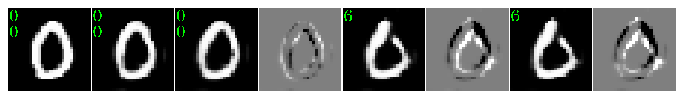

*** MNIST, CLASS 1, RECONSTRUCTED ***
noise_epsilon = 1.00000, decay_factor = 0.29289
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


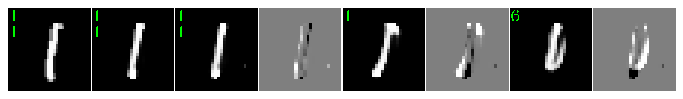

*** MNIST, CLASS 2, RECONSTRUCTED ***
noise_epsilon = 1.00000, decay_factor = 0.29289
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


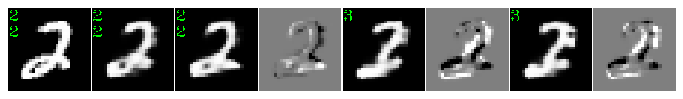

*** MNIST, CLASS 3, RECONSTRUCTED ***
noise_epsilon = 1.00000, decay_factor = 0.29289
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


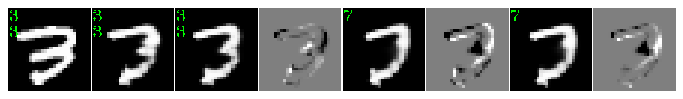

*** MNIST, CLASS 4, RECONSTRUCTED ***
noise_epsilon = 1.00000, decay_factor = 0.29289
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


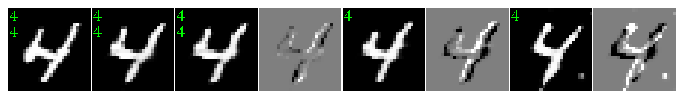

*** MNIST, CLASS 5, RECONSTRUCTED ***
noise_epsilon = 1.00000, decay_factor = 0.29289
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


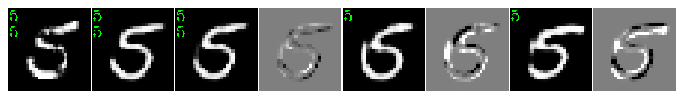

*** MNIST, CLASS 6, RECONSTRUCTED ***
noise_epsilon = 1.00000, decay_factor = 0.29289
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


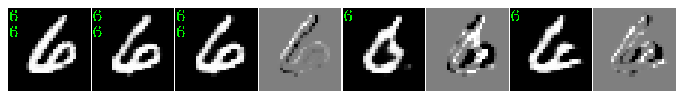

*** MNIST, CLASS 7, RECONSTRUCTED ***
noise_epsilon = 1.00000, decay_factor = 0.29289
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


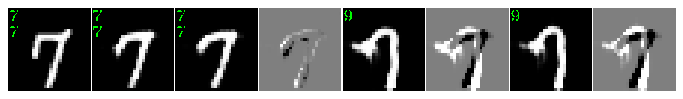

*** MNIST, CLASS 8, RECONSTRUCTED ***
noise_epsilon = 1.00000, decay_factor = 0.29289
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


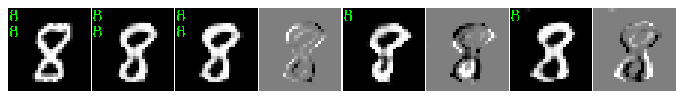

*** MNIST, CLASS 9, RECONSTRUCTED ***
noise_epsilon = 1.00000, decay_factor = 0.29289
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


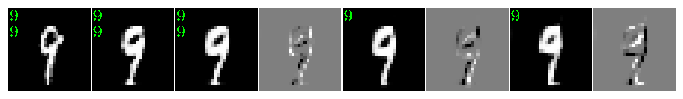

*** STATISTICS ***
Accuracy of classifier 0 on 10      original images: 100.00%
Accuracy of classifier 1 on 10      original images: 100.00%
Accuracy of classifier 0 on 10 reconstructed images: 100.00%
Accuracy of classifier 1 on 10 reconstructed images: 100.00%
Accuracy of classifier 0 on 10       decayed images: 100.00%
Accuracy of classifier 1 on 10       decayed images: 100.00%
Accuracy of classifier 0 on 10     perturbed images: 60.00%
Accuracy of classifier 1 on 10     perturbed images: 50.00%
For classifier 0 and 10 images,             ||dl|| (scaled L2): mean=0.25544, std=0.05205, Q0=0.16279, Q1=0.21369, Q2=0.27547, Q3=0.29657, Q4=0.30000
For classifier 1 and 10 images,             ||dl|| (scaled L2): mean=0.23263, std=0.08044, Q0=0.11612, Q1=0.15352, Q2=0.27710, Q3=0.30000, Q4=0.30000
For classifier 0 and 10 images, ||l + dl|| - ||l|| (scaled L2): mean=0.04943, std=0.03429, Q0=-0.00876, Q1=0.03249, Q2=0.05292, Q3=0.07246, Q4=0.10358
For classifier 1 and 10 images, ||l + dl|| -

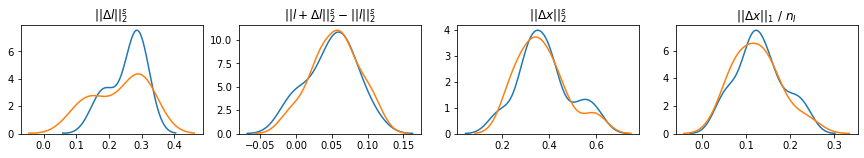

*** MNIST, CLASS 0, GENERATED ***
noise_epsilon = 1.00000, decay_factor = 0.29289
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


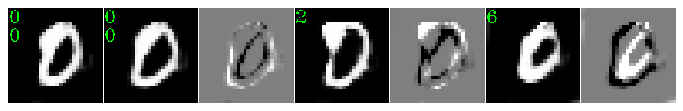

*** MNIST, CLASS 1, GENERATED ***
noise_epsilon = 1.00000, decay_factor = 0.29289
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


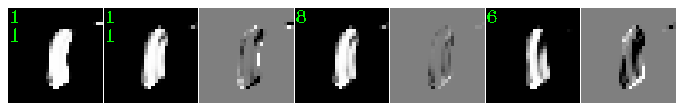

*** MNIST, CLASS 2, GENERATED ***
noise_epsilon = 1.00000, decay_factor = 0.29289
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


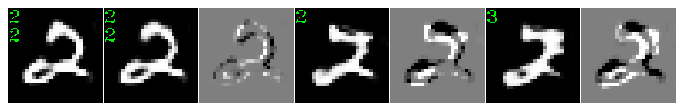

*** MNIST, CLASS 3, GENERATED ***
noise_epsilon = 1.00000, decay_factor = 0.29289
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


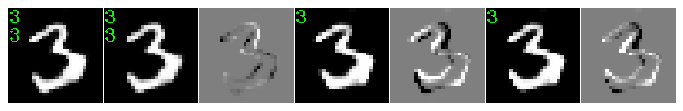

*** MNIST, CLASS 4, GENERATED ***
noise_epsilon = 1.00000, decay_factor = 0.29289
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


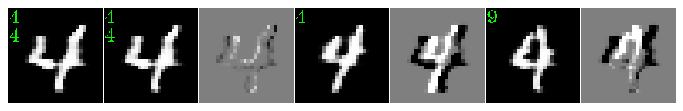

*** MNIST, CLASS 5, GENERATED ***
noise_epsilon = 1.00000, decay_factor = 0.29289
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


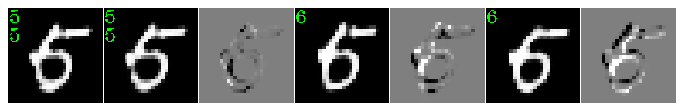

*** MNIST, CLASS 6, GENERATED ***
noise_epsilon = 1.00000, decay_factor = 0.29289
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


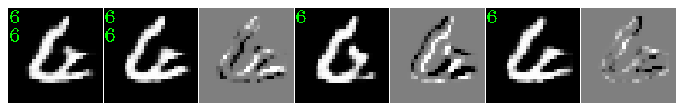

*** MNIST, CLASS 7, GENERATED ***
noise_epsilon = 1.00000, decay_factor = 0.29289
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


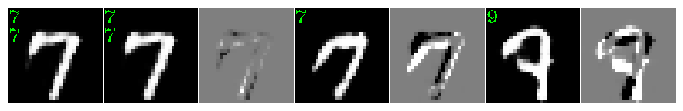

*** MNIST, CLASS 8, GENERATED ***
noise_epsilon = 1.00000, decay_factor = 0.29289
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


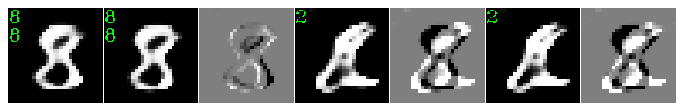

*** MNIST, CLASS 9, GENERATED ***
noise_epsilon = 1.00000, decay_factor = 0.29289
generator: 42051 trainable parameters
discriminator: 41221 trainable parameters


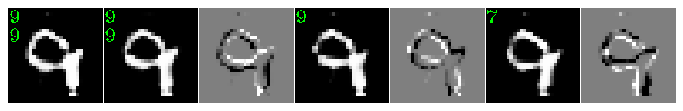

*** STATISTICS ***
Accuracy of classifier 0 on 10     generated images: 100.00%
Accuracy of classifier 1 on 10     generated images: 100.00%
Accuracy of classifier 0 on 10       decayed images: 100.00%
Accuracy of classifier 1 on 10       decayed images: 100.00%
Accuracy of classifier 0 on 10     perturbed images: 60.00%
Accuracy of classifier 1 on 10     perturbed images: 20.00%
For classifier 0 and 10 images,             ||dl|| (scaled L2): mean=0.24520, std=0.06588, Q0=0.10983, Q1=0.19721, Q2=0.27328, Q3=0.30000, Q4=0.30000
For classifier 1 and 10 images,             ||dl|| (scaled L2): mean=0.25741, std=0.06042, Q0=0.14033, Q1=0.24412, Q2=0.28683, Q3=0.30000, Q4=0.30000
For classifier 0 and 10 images, ||l + dl|| - ||l|| (scaled L2): mean=0.04566, std=0.02370, Q0=0.01732, Q1=0.02653, Q2=0.04055, Q3=0.06645, Q4=0.08527
For classifier 1 and 10 images, ||l + dl|| - ||l|| (scaled L2): mean=0.06361, std=0.03743, Q0=0.01406, Q1=0.03961, Q2=0.04908, Q3=0.08660, Q4=0.13361
For classifier 0 

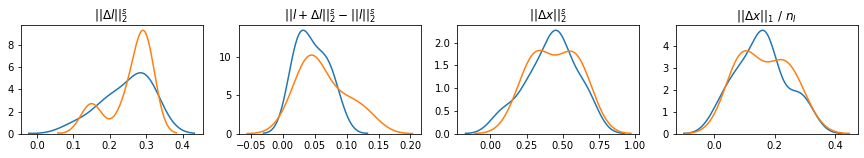

In [6]:
total_images = 10
rho, noise_eps = 0.3, 1.0
# search with restarts (a sequence of restarts will terminate if an adversarial perturbation is found)
adversary = PGDAdversary(rho, 50, 0.05, True, 0, verbose=0, n_repeat=12, repeat_mode="any")
advgen_experiments(adversary, noise_eps, total_images)